# Find outliers with unusual entropy
Inspired by the pre-processing step from the paper http://openaccess.thecvf.com/content_cvpr_2018/CameraReady/2763.pdf

> <b>Noise Removal with Image Entropy</b>
> Key ingredient to a successful sketch center loss is the guarantee of non-noisy data (outliers), as it will significantly affect the class feature centers. However, sketch data collected with crowdsourcing are inevitable to noise, where we propose a noisy data removal technique to alleviate such issue by resorting to image entropy. Given a category of sketch, we can get entropy for each sketch and the overall entropy distribution on a category basis. We empirically find that keeping the middle 90% of each category as normal samples gives us best results. In Figure 4, we visualize the entropy histogram of star samples in our training set. If we choose the middle 90% samples as normal samples for star category, we can calculate and get the 0.05 and 0.95 percentiles of star images entropy as 0.1051 and 0.1721, respectively. We then treat the remaining samples as outliers or noise points (entropy ∈ [0, 0.1051)   (0.1721, 1]). It can be observed that low entropy sketches tend to be overly-abstract, yet high entropy ones being messy, sometimes with meaningless scribbles. Nevertheless, sketch data falling into middle entropy range present more consistent and reasonable drawings.


In [1]:
import ast
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dask import bag # 并行处理数据
from tqdm import tqdm
import cv2

In [2]:
def entropy_it(x):
    counts = np.bincount(x) # 计算x中 0-255这些数字的出现次数
    p = counts[counts > 0] / float(len(x)) # 归一化成概率
    # compute Shannon entropy in bits
    return -np.sum(p * np.log2(p))

# PIL 比 cv2慢一些
# def draw_it(strokes):
#     image = Image.new("P", (256,256), color=255)
#     draw = ImageDraw.Draw(image)
#     for stroke in ast.literal_eval(strokes):
#         for i in range(len(stroke[0])-1):
#             draw.line([stroke[0][i], stroke[1][i], stroke[0][i+1], stroke[1][i+1]], fill=0, width=5)
#     image = np.array(image)
#     return entropy_it(image.flatten()), image

def draw_cv2(strokes):
    """
    将一个涂鸦数据转换成一张黑百图, (size, size, channel)
    time_color: 若为true, 则每一笔颜色不一样,随着时间推移而变浅. 若为false,则颜色都为纯黑
    lw: 线段宽度
    point_drop_prob: 以此概率丢弃掉point, 0.05 - 0.15差不多
    channel: 必须为1或3

    """
    img = np.zeros((256, 256), np.uint8)
    
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, 5) # color是一个标量所以生成黑白图
    return entropy_it(img.flatten()), img


def get_entropy(strokes):
    image = Image.new("P", (256,256), color=255)
    draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            draw.line([stroke[0][i], stroke[1][i], stroke[0][i+1], stroke[1][i+1]], fill=0, width=5)
    image = np.array(image)
    return entropy_it(image.flatten())


def plot_it(entropy, images, indices, n=5):
    fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(25, 10))
    for i, j in enumerate(indices[0][:n*n]):
        ax = axs[i // n, i % n]
        ax.set_title("%.4f" % entropy[j])
        ax.imshow(images[j], cmap="gray")
        ax.set_yticks([])
        ax.set_xticks([])
        plt.setp(ax.spines.values(), color="red")
    plt.subplots_adjust(bottom=-0.2)
    plt.show()

In [3]:
reader = pd.read_csv('../input/shuffled_csv/train_1_100.csv.gz', chunksize=1024, nrows=1024*50) # 设置nrows以测试
# reader = pd.read_csv('../input/test_simplified.csv', index_col=['key_id'], chunksize=1024, nrows=10240)

data = []
for chunk in tqdm(reader):
    # bag.from_sequence从序列创造一个bag用于并行处理
    entropybag = bag.from_sequence(chunk.drawing.values).map(draw_cv2)
    data.extend(entropybag.compute()) # PARALLELIZE

entropy, images = zip(*data)

50it [02:42,  3.26s/it]


## Keep 98% of samples

In [4]:
threshold = 1
lower = np.percentile(entropy, threshold)
upper = np.percentile(entropy, 100 - threshold)
print("所有entropy落在 [%.4f, %.4f] 之间" % (np.min(entropy), np.max(entropy)))
print("%.2f%%的entropy落在 [%.4f, %.4f] 之间." % (100.0 - 2.0*threshold, lower, upper))

所有entropy落在 [0.0502, 0.9998] 之间
98.00%的entropy落在 [0.2133, 0.8097] 之间.


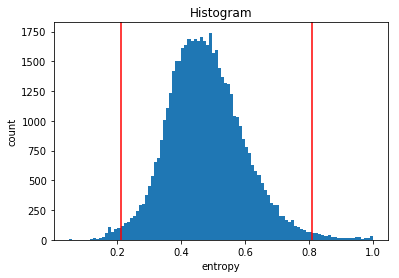

In [5]:
plt.title("Histogram")
plt.xlabel('entropy')
plt.ylabel('count')
plt.hist(entropy, bins=100)
plt.axvline(x=lower, color='r')
plt.axvline(x=upper, color='r')

## Low entropy samples

低于lower = 0.2133 的样本:


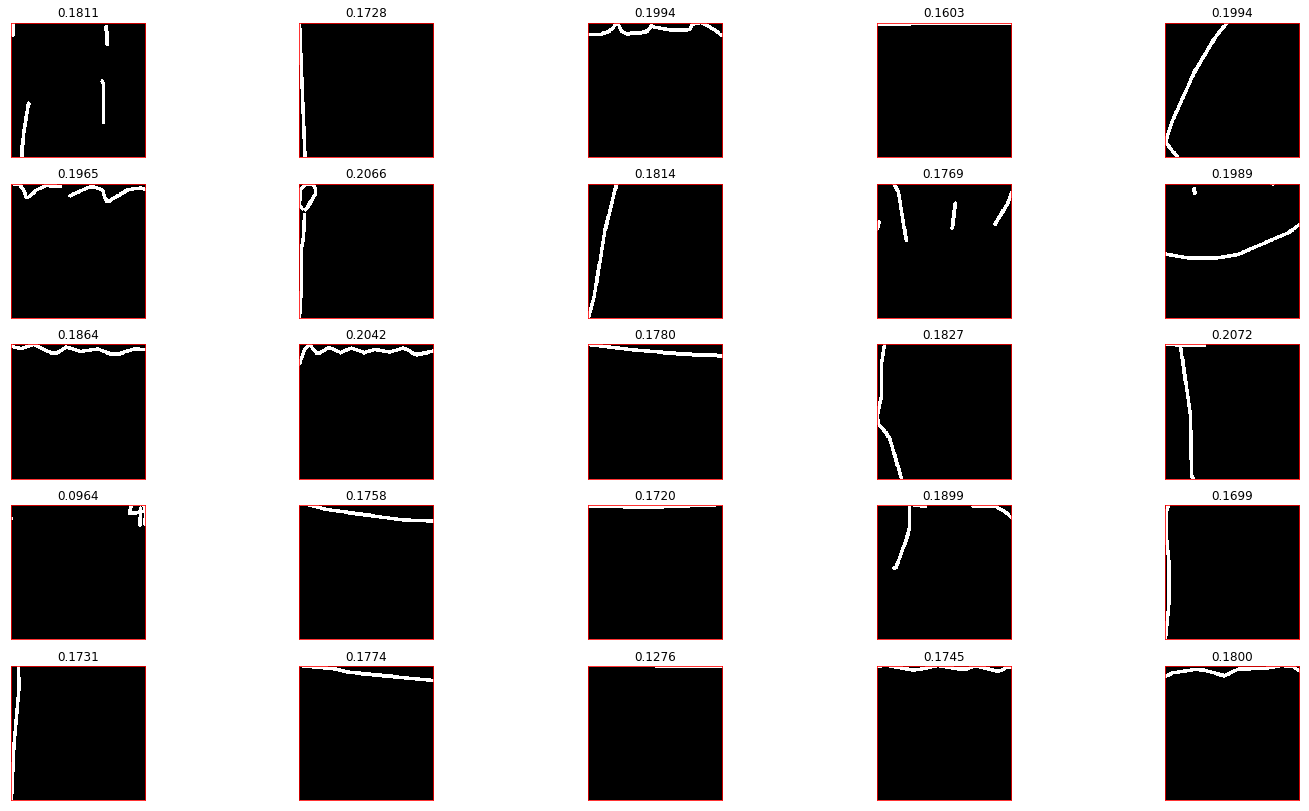

In [6]:
print("低于lower = %.4f 的样本示例:" % lower)
plot_it(entropy, images, np.where(entropy < lower))

## High entropy samples

高于upper = 0.8097 的样本:


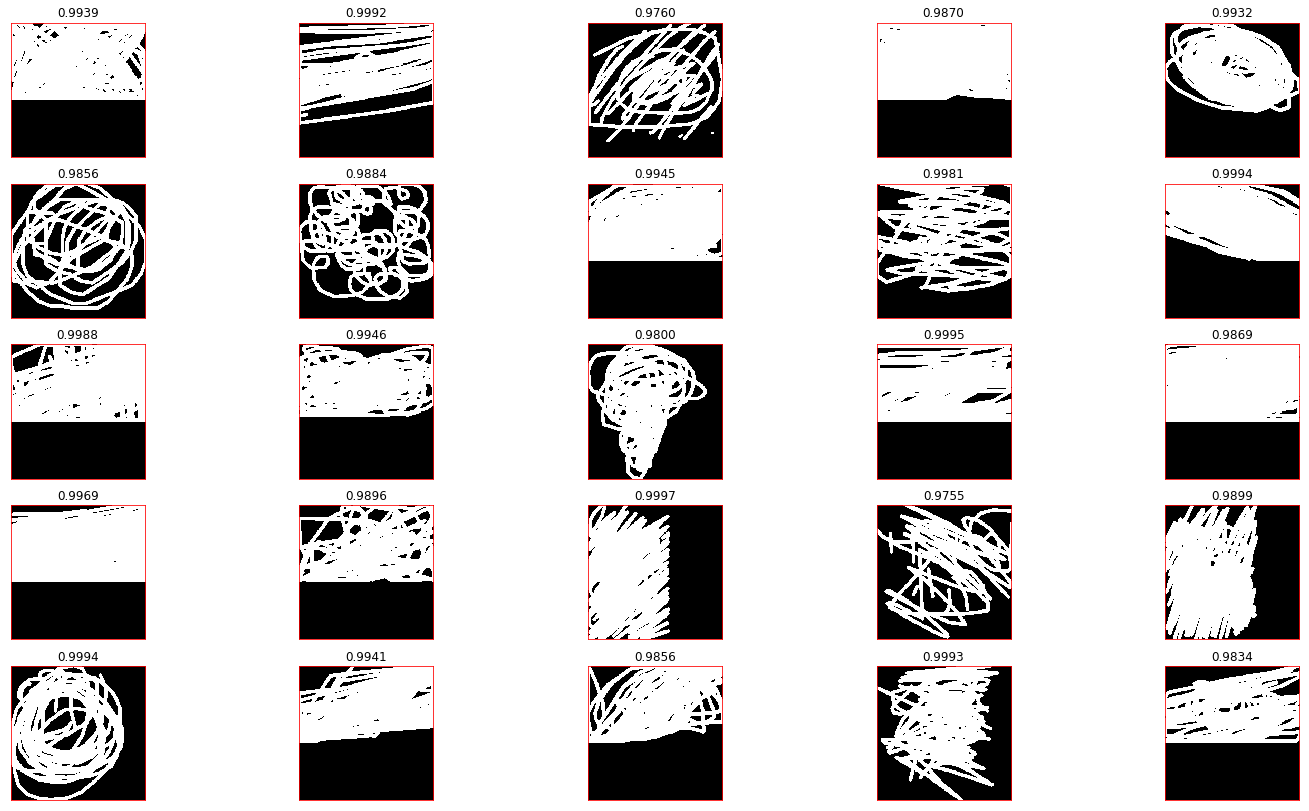

In [7]:
print("高于upper = %.4f 的样本示例:" % upper)
plot_it(entropy, images, np.where(entropy > upper+0.16))